In [2]:
import numpy as np
import pandas as pd
from sktime.forecasting.model_selection import (
    ForecastingGridSearchCV,
    SlidingWindowSplitter,
    temporal_train_test_split)
from sktime.forecasting.base import ForecastingHorizon
from sktime.utils.plotting import plot_series
from sktime.performance_metrics.forecasting import sMAPE, smape_loss
import time
from fbprophet import Prophet
import itertools
from fbprophet.diagnostics import cross_validation as fb_cross_validation
from fbprophet.diagnostics import performance_metrics
#from fbprophet.diagnostics import performance_metrics

In [4]:
sales=pd.read_csv('y_df.csv')
sales.date= pd.to_datetime(sales.date)
sales = sales.set_index('date')
sales.head()

,total_sales
date,
2011-01-29,32631.0
2011-01-30,31749.0
2011-01-31,23783.0
2011-02-01,25412.0
2011-02-02,19146.0


In [5]:
y=sales['total_sales']
y= y.asfreq('d')
y

NameError: name 'sales_df' is not defined

In [6]:
y_df=y.reset_index().rename(columns={'date':'ds','total_sales':'y'})
y= y.asfreq('d')
z = y_df.copy()

z_train, z_test = temporal_train_test_split(z, test_size=28)

In [7]:
z_test.shape

(28, 2)

In [8]:
z= z.asfreq('d')


,ds,y
0,2011-01-29,32631.0
1,2011-01-30,31749.0
2,2011-01-31,23783.0
3,2011-02-01,25412.0
4,2011-02-02,19146.0
...,...,...
1936,2016-05-18,37096.0
1937,2016-05-19,36963.0
1938,2016-05-20,42552.0
1939,2016-05-21,51518.0


In [11]:
cal=pd.read_csv('calendar.csv')

In [147]:
def format_holidays(cal):
    df_ev_1 = pd.DataFrame({'holiday': 'Event 1', 'ds': cal[~cal['event_name_1'].isna()]['date']})
    df_ev_2 = pd.DataFrame({'holiday': 'Event 2', 'ds': cal[~cal['event_name_2'].isna()]['date']})
    df_ev_3 = pd.DataFrame({'holiday': 'snap_CA', 'ds': cal[cal['snap_CA'] == 1]['date']})
    df_ev_4 = pd.DataFrame({'holiday': 'snap_TX', 'ds': cal[cal['snap_TX'] == 1]['date']})
    df_ev_5 = pd.DataFrame({'holiday': 'snap_WI', 'ds': cal[cal['snap_WI'] == 1]['date']})
    holidays = pd.concat((df_ev_1, df_ev_2, df_ev_3, df_ev_4, df_ev_5))

    holidays['ds'] = pd.to_datetime(holidays['ds'])
    return holidays
holidays = format_holidays(cal)

In [34]:
best_params = all_params[np.argmin(rmses)]
print(best_params)
#print(b)

{'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10, 'changepoint_range': 0.95, 'seasonality_mode': 'multiplicative'}


In [59]:
%%time
m = Prophet(changepoint_prior_scale=0.1,
                seasonality_prior_scale=10,
                changepoint_range=0.95,
                seasonality_mode="multiplicative",
                #**params,
                holidays=holidays,
                daily_seasonality=True,
                weekly_seasonality=True, 
                yearly_seasonality=True).fit(z_train)
df_cv_1day = cross_validation(m, initial='1200 days', period='180 days', horizon = '1 days',parallel="processes")

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000022510B00B80>


Wall time: 1min 28s


In [61]:
smape_loss(df_cv_1day['y'],df_cv_1day['yhat'])

0.015684170349180286

In [62]:
%%time
m = Prophet(changepoint_prior_scale=0.1,
                seasonality_prior_scale=10,
                changepoint_range=0.95,
                seasonality_mode="multiplicative",
                #**params,
                holidays=holidays,
                daily_seasonality=True,
                weekly_seasonality=True, 
                yearly_seasonality=True).fit(z_train)
df_cv_28day = cross_validation(m, initial='1200 days', period='180 days', horizon = '28 days',parallel="processes")
smape_loss(df_cv_28day['y'],df_cv_28day['yhat'])

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-04 00:00:00 and 2016-03-27 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000002251168FFD0>


Wall time: 1min 16s


0.03287649214391335

In [64]:
%%time
m = Prophet(changepoint_prior_scale=0.1,
                seasonality_prior_scale=10,
                changepoint_range=0.95,
                seasonality_mode="multiplicative",
                #**params,
                holidays=holidays,
                daily_seasonality=True,
                weekly_seasonality=True, 
                yearly_seasonality=True,
                fh=1).fit(z_train)

TypeError: __init__() got an unexpected keyword argument 'fh'

In [63]:
df_cv_28day

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2014-10-05,46999.584653,43915.721600,50272.021462,48361.0,2014-10-04
1,2014-10-06,38381.924060,35216.862233,41458.158605,37719.0,2014-10-04
2,2014-10-07,33500.891694,30310.579674,36628.310254,33151.0,2014-10-04
3,2014-10-08,33193.771609,30179.591394,36489.077059,33185.0,2014-10-04
4,2014-10-09,35335.395043,32193.177453,38685.530614,33738.0,2014-10-04
...,...,...,...,...,...,...
107,2016-04-20,35471.382219,32038.083879,38950.044810,35343.0,2016-03-27
108,2016-04-21,35740.082982,32224.327346,38998.880810,35033.0,2016-03-27
109,2016-04-22,40585.340092,37055.714696,43812.438886,40517.0,2016-03-27
110,2016-04-23,49945.636962,46327.878691,53560.343280,48962.0,2016-03-27


In [70]:
import warnings
warnings.filterwarnings("ignore")

In [18]:
fb_param_grid = {  
    'changepoint_prior_scale': np.logspace(0.001, 0.5, 6),
    'seasonality_prior_scale': np.logspace(0.01, 10, 8),
    'holidays_prior_scale':  np.logspace(0.01, 10, 6),
    'changepoint_range': [0.95],
    'seasonality_mode': ["multiplicative"]
}
cv_param_grid = {
              #'model' : [m]
               'initial' : ['1200 days']
              , 'period'  : ['180 days']
              , 'horizon' : ['1 days']
              }

#cutoffs = pd.to_datetime(['2013-12-25','2013-06-25','2014-12-25','201-06-25', '2016-05-22'])
# Generate all combinations of parameters
all_params_fb = [dict(zip(fb_param_grid.keys(), v)) for v in itertools.product(*fb_param_grid.values())]
all_params_cv = [dict(zip(cv_param_grid.keys(), v)) for v in itertools.product(*cv_param_grid.values())]
rmses_cv = []  # Store the RMSEs for each params here
smape_cv = [] 
results_cv={}
# Use cross validation to evaluate all parameters
for i, params in enumerate(all_params_cv):
    t0=time.time()
    rmses = []  # Store the RMSEs for each params here
    smape = [] 
    for j, params_fb in enumerate(all_params_fb):
        t1=time.time()
        m = Prophet(#changepoint_prior_scale=0.1,
                #seasonality_prior_scale=10,
                #changepoint_range=0.95,
                #seasonality_mode="multiplicative",
            **params_fb,
            holidays=holidays,
            daily_seasonality=True,
            weekly_seasonality=True, 
            yearly_seasonality=True).fit(z_train)  # Fit model with given params
        #df_cv = cross_validation(m, cutoffs=cutoffs, horizon='28 days', parallel="processes")
        #df_cv = cross_validation(m, initial='365.25 days', period='120 days', horizon = '28 days',parallel="processes")
        df_cv = fb_cross_validation(m, initial=params['initial'], period=params['period'], 
                                    horizon = params['horizon'],parallel="processes")
        #print(df_cv)
        df_p = performance_metrics(df_cv, rolling_window=1)
        smape.append(smape_loss(df_cv['y'], df_cv['yhat']))
        rmses.append(df_p['rmse'].values[0])
        #smape_loss(z_test, df_cv['yhat'])
        print(f"Parameter choice {j+1}, cv {i+1}, time: {time.time()-t1}, smape: {smape}")
        
    print(f"cv {i+1} complete in {time.time()-t0} sec.")
        
    rmses_cv.append(rmses)
    smape_cv.append(smape)
    np.save('smape.csv', np.array(smape_cv))
    np.save('rmses.csv', np.array(rmses_cv))
    
smape_cv_np= np.array(smape_cv)
idx_best_score = np.unravel_index(smape_cv_np.argmin(),smape_cv_np.shape)
best_params_fb_cv = (all_params_cv[idx_best_score[0]], all_params_fb[idx_best_score[1]])  
cv_results = pd.DataFrame([{**cv, **fb} for cv in all_params_cv for fb in all_params_fb])
cv_results['smape'] = smape_cv_np.ravel()
cv_results['rmse'] = np.array(rmses_cv).reshape(len(rmses_cv)*len(rmses_cv[0]))
cv_results = cv_results.sort_values('smape')
cv_results.to_csv('cv_results.csv', index=False)
cv_results

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE587DC790>


Parameter choice 1, cv 1, time: 58.29329991340637, smape: [0.025762885327071383]


INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE587DCC10>


Parameter choice 2, cv 1, time: 60.62497138977051, smape: [0.025762885327071383, 0.01747020926484214]


INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE58894040>


Parameter choice 3, cv 1, time: 63.851534605026245, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162]


INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE587DC790>


Parameter choice 4, cv 1, time: 56.998939514160156, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094]


INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE587DCBE0>


Parameter choice 5, cv 1, time: 62.389923334121704, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588]


INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE5881EA60>


Parameter choice 6, cv 1, time: 61.533836126327515, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037]


INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE587E4220>


Parameter choice 7, cv 1, time: 56.83426308631897, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279]


INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE587EE190>


Parameter choice 8, cv 1, time: 63.67085647583008, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339]


INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE58894130>


Parameter choice 9, cv 1, time: 63.07705068588257, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958]


INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE5881E760>


Parameter choice 10, cv 1, time: 59.47298049926758, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458]


INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE587E43A0>


Parameter choice 11, cv 1, time: 63.490447759628296, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665]


INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE5888F550>


Parameter choice 12, cv 1, time: 62.31160569190979, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625]


INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE50D47D90>


Parameter choice 13, cv 1, time: 53.535834312438965, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823]


INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE5888F9A0>


Parameter choice 14, cv 1, time: 54.89477777481079, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768]


INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE5888F430>


Parameter choice 15, cv 1, time: 51.89422249794006, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856]


INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE587E45E0>


Parameter choice 16, cv 1, time: 56.38920021057129, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246]


INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE588738E0>


Parameter choice 17, cv 1, time: 50.610769748687744, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746]


INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE50D47F70>


Parameter choice 18, cv 1, time: 51.2238404750824, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463]


INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE587DCBE0>


Parameter choice 19, cv 1, time: 54.61159873008728, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535]


INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE586473A0>


Parameter choice 20, cv 1, time: 53.824286460876465, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834]


INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE5132BB20>


Parameter choice 21, cv 1, time: 50.05713510513306, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203]


INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE5888F1F0>


Parameter choice 22, cv 1, time: 52.22134613990784, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316]


INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE587EE310>


Parameter choice 23, cv 1, time: 52.06382441520691, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663]


INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE587EE430>


Parameter choice 24, cv 1, time: 57.17708778381348, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407]


INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE5888FA90>


Parameter choice 25, cv 1, time: 48.29088091850281, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831]


INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE5888FA90>


Parameter choice 26, cv 1, time: 47.860933780670166, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904]


INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE58865700>


Parameter choice 27, cv 1, time: 50.14789080619812, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445]


INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE58838C40>


Parameter choice 28, cv 1, time: 53.20595598220825, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367]


INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE588738E0>


Parameter choice 29, cv 1, time: 50.80712819099426, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585]


INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE587E41F0>


Parameter choice 30, cv 1, time: 51.895219564437866, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276]


INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE587EE5B0>


Parameter choice 31, cv 1, time: 51.09834909439087, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181]


INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE5881EB50>


Parameter choice 32, cv 1, time: 52.94041562080383, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867]


INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE50CDEA60>


Parameter choice 33, cv 1, time: 55.02496576309204, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657]


INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE50D47F70>


Parameter choice 34, cv 1, time: 60.00153827667236, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884]


INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE587E40A0>


Parameter choice 35, cv 1, time: 58.1106321811676, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186]


INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE587E4430>


Parameter choice 36, cv 1, time: 57.25987219810486, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486]


INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE58865F10>


Parameter choice 37, cv 1, time: 47.55682110786438, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508]


INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE5885C4C0>


Parameter choice 38, cv 1, time: 58.643173933029175, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043]


INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE58838D30>


Parameter choice 39, cv 1, time: 58.01385736465454, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239]


INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE58647040>


Parameter choice 40, cv 1, time: 53.1709201335907, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913]


INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE587E4370>


Parameter choice 41, cv 1, time: 52.40544676780701, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313]


INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE58838D30>


Parameter choice 42, cv 1, time: 49.13777017593384, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235]


INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE587EE3A0>


Parameter choice 43, cv 1, time: 45.980111837387085, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066]


INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE587EE280>


Parameter choice 44, cv 1, time: 58.76982378959656, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.02489918157

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE588651F0>


Parameter choice 45, cv 1, time: 57.35661029815674, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.02489918157

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE587EE3D0>


Parameter choice 46, cv 1, time: 52.67557501792908, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.02489918157

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE587E43A0>


Parameter choice 47, cv 1, time: 52.555073499679565, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.0248991815

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE587E40A0>


Parameter choice 48, cv 1, time: 49.857948303222656, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.0248991815

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE5885C970>


Parameter choice 49, cv 1, time: 47.98644495010376, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.02489918157

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE588738E0>


Parameter choice 50, cv 1, time: 49.954822063446045, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.0248991815

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE50D47D90>


Parameter choice 51, cv 1, time: 48.555811643600464, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.0248991815

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE50DD5280>


Parameter choice 52, cv 1, time: 48.03885555267334, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.02489918157

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE58865D00>


Parameter choice 53, cv 1, time: 50.12594485282898, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.02489918157

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE587DC760>


Parameter choice 54, cv 1, time: 49.43127155303955, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.02489918157

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE58865CD0>


Parameter choice 55, cv 1, time: 51.31024169921875, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.02489918157

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE587E4400>


Parameter choice 56, cv 1, time: 59.48221778869629, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.02489918157

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE58865430>


Parameter choice 57, cv 1, time: 52.469764709472656, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.0248991815

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE5888F640>


Parameter choice 58, cv 1, time: 53.33463525772095, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.02489918157

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE587E4400>


Parameter choice 59, cv 1, time: 47.14759945869446, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.02489918157

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE587DC760>


Parameter choice 60, cv 1, time: 51.890620946884155, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.0248991815

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE58865D00>


Parameter choice 61, cv 1, time: 54.60711693763733, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.02489918157

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE587EE2B0>


Parameter choice 62, cv 1, time: 48.10425615310669, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.02489918157

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE58865CD0>


Parameter choice 63, cv 1, time: 56.53302335739136, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.02489918157

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE587EE340>


Parameter choice 64, cv 1, time: 51.52882695198059, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.02489918157

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE58865D00>


Parameter choice 65, cv 1, time: 64.4380624294281, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.024899181575

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE3F74F1C0>


Parameter choice 66, cv 1, time: 66.23490786552429, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.02489918157

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE50DD5280>


Parameter choice 67, cv 1, time: 49.391392946243286, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.0248991815

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE58838F70>


Parameter choice 68, cv 1, time: 51.85605597496033, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.02489918157

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE58647430>


Parameter choice 69, cv 1, time: 53.090925216674805, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.0248991815

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE587EE190>


Parameter choice 70, cv 1, time: 53.34437823295593, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.02489918157

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE587E4D00>


Parameter choice 71, cv 1, time: 50.61318492889404, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.02489918157

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE58838C10>


Parameter choice 72, cv 1, time: 51.8528413772583, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.024899181575

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE58647340>


Parameter choice 73, cv 1, time: 55.20488381385803, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.02489918157

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE513C23A0>


Parameter choice 74, cv 1, time: 52.71245741844177, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.02489918157

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE587E4AC0>


Parameter choice 75, cv 1, time: 55.31399416923523, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.02489918157

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE5888FB20>


Parameter choice 76, cv 1, time: 52.23860001564026, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.02489918157

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE58838D60>


Parameter choice 77, cv 1, time: 49.112555503845215, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.0248991815

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE587DCBE0>


Parameter choice 78, cv 1, time: 48.919034481048584, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.0248991815

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE587EE400>


Parameter choice 79, cv 1, time: 49.79679322242737, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.02489918157

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE5881E250>


Parameter choice 80, cv 1, time: 52.70599603652954, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.02489918157

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE587EE2B0>


Parameter choice 81, cv 1, time: 55.4167685508728, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.024899181575

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE587FB2B0>


Parameter choice 82, cv 1, time: 56.088019132614136, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.0248991815

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE58647430>


Parameter choice 83, cv 1, time: 53.57741856575012, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.02489918157

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE46BA5520>


Parameter choice 84, cv 1, time: 54.4327175617218, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.024899181575

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE587EE370>


Parameter choice 85, cv 1, time: 50.567768573760986, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.0248991815

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE587EE5B0>


Parameter choice 86, cv 1, time: 61.51516318321228, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.02489918157

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE5885C340>


Parameter choice 87, cv 1, time: 56.64464473724365, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.02489918157

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE5885CA90>


Parameter choice 88, cv 1, time: 67.88252568244934, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.02489918157

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE5888FC70>


Parameter choice 89, cv 1, time: 58.66705012321472, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.02489918157

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE587DC760>


Parameter choice 90, cv 1, time: 54.44432711601257, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.02489918157

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE588655E0>


Parameter choice 91, cv 1, time: 51.1418035030365, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.024899181575

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE513C23A0>


Parameter choice 92, cv 1, time: 76.27368211746216, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.02489918157

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE587EE370>


Parameter choice 93, cv 1, time: 56.149834394454956, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.0248991815

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE5132B760>


Parameter choice 94, cv 1, time: 52.216087102890015, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.0248991815

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE587E41C0>


Parameter choice 95, cv 1, time: 68.4480288028717, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.024899181575

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE587DC760>


Parameter choice 96, cv 1, time: 73.56983661651611, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.02489918157

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE5888B1F0>


Parameter choice 97, cv 1, time: 55.226640939712524, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.0248991815

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE5885CE80>


Parameter choice 98, cv 1, time: 56.73014211654663, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.02489918157

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE3F74F1C0>


Parameter choice 99, cv 1, time: 53.601438999176025, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.0248991815

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE587FB2B0>


Parameter choice 100, cv 1, time: 47.46605205535889, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.0248991815

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE586473A0>


Parameter choice 101, cv 1, time: 52.63782453536987, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.0248991815

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE587EE670>


Parameter choice 102, cv 1, time: 52.36724829673767, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.0248991815

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE587E4D00>


Parameter choice 103, cv 1, time: 53.496161699295044, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.024899181

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE586473A0>


Parameter choice 104, cv 1, time: 51.81442880630493, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.0248991815

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE5881E4C0>


Parameter choice 105, cv 1, time: 59.17070698738098, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.0248991815

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE50CDEA60>


Parameter choice 106, cv 1, time: 56.40350556373596, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.0248991815

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE5881E970>


Parameter choice 107, cv 1, time: 51.22401523590088, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.0248991815

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE587E4AC0>


Parameter choice 108, cv 1, time: 51.12577414512634, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.0248991815

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE58894040>


Parameter choice 109, cv 1, time: 48.82300901412964, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.0248991815

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE587DCBE0>


Parameter choice 110, cv 1, time: 60.07527160644531, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.0248991815

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE5881E250>


Parameter choice 111, cv 1, time: 57.60247802734375, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.0248991815

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE586473A0>


Parameter choice 112, cv 1, time: 52.18432021141052, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.0248991815

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE5881EC10>


Parameter choice 113, cv 1, time: 50.715376138687134, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.024899181

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE5881E250>


Parameter choice 114, cv 1, time: 50.43359708786011, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.0248991815

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE5881E460>


Parameter choice 115, cv 1, time: 58.947975158691406, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.024899181

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE5885C760>


Parameter choice 116, cv 1, time: 51.03446054458618, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.0248991815

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE50DD54F0>


Parameter choice 117, cv 1, time: 47.102980852127075, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.024899181

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE58894040>


Parameter choice 118, cv 1, time: 59.97175049781799, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.0248991815

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE587EE670>


Parameter choice 119, cv 1, time: 53.729641914367676, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.024899181

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE587EE460>


Parameter choice 120, cv 1, time: 54.12051439285278, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.0248991815

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE587EE280>


Parameter choice 121, cv 1, time: 48.717865228652954, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.024899181

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE50D47F70>


Parameter choice 122, cv 1, time: 57.29577589035034, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.0248991815

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE5888BD30>


Parameter choice 123, cv 1, time: 49.32222294807434, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.0248991815

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE587EE310>


Parameter choice 124, cv 1, time: 52.08891820907593, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.0248991815

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE5888BA00>


Parameter choice 125, cv 1, time: 49.20061206817627, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.0248991815

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE58838E20>


Parameter choice 126, cv 1, time: 51.01073241233826, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.0248991815

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE58838400>


Parameter choice 127, cv 1, time: 50.12682580947876, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.0248991815

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE5888BD30>


Parameter choice 128, cv 1, time: 47.37879204750061, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.0248991815

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE58865A30>


Parameter choice 129, cv 1, time: 50.325934171676636, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.024899181

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE587E43A0>


Parameter choice 130, cv 1, time: 53.018757343292236, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.024899181

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE5132B760>


Parameter choice 131, cv 1, time: 50.62592935562134, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.0248991815

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE587DC760>


Parameter choice 132, cv 1, time: 53.4634313583374, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.02489918157

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE50CDEA60>


Parameter choice 133, cv 1, time: 48.902259349823, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.024899181575

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE5888B6A0>


Parameter choice 134, cv 1, time: 49.859570026397705, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.024899181

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE587EE400>


Parameter choice 135, cv 1, time: 53.919429063797, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.024899181575

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE5888B190>


Parameter choice 136, cv 1, time: 52.13956665992737, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.0248991815

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE5132B760>


Parameter choice 137, cv 1, time: 50.22468566894531, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.0248991815

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE587E4430>


Parameter choice 138, cv 1, time: 50.43373656272888, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.0248991815

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE587EE670>


Parameter choice 139, cv 1, time: 49.91863536834717, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.0248991815

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE586473A0>


Parameter choice 140, cv 1, time: 50.73698830604553, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.0248991815

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE5888FCD0>


Parameter choice 141, cv 1, time: 53.9337637424469, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.02489918157

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE586473A0>


Parameter choice 142, cv 1, time: 52.10850477218628, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.0248991815

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE5888FEB0>


Parameter choice 143, cv 1, time: 49.4392569065094, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.02489918157

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE587E43A0>


Parameter choice 144, cv 1, time: 50.53180408477783, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.0248991815

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE587E4B80>


Parameter choice 145, cv 1, time: 49.52366876602173, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.0248991815

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE587E41C0>


Parameter choice 146, cv 1, time: 54.965598821640015, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.024899181

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE58865070>


Parameter choice 147, cv 1, time: 61.35572600364685, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.0248991815

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE58865400>


Parameter choice 148, cv 1, time: 60.21960186958313, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.0248991815

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE587FB2B0>


Parameter choice 149, cv 1, time: 56.61568212509155, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.0248991815

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE587E4C10>


Parameter choice 150, cv 1, time: 82.2964129447937, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.02489918157

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE587E4370>


Parameter choice 151, cv 1, time: 92.97935605049133, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.0248991815

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE587E4160>


Parameter choice 152, cv 1, time: 58.99724102020264, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.0248991815

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE587E4400>


Parameter choice 153, cv 1, time: 63.49856233596802, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.0248991815

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE586471F0>


Parameter choice 154, cv 1, time: 44.54039764404297, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.0248991815

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE58865C10>


Parameter choice 155, cv 1, time: 55.86660432815552, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.0248991815

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE58865CD0>


Parameter choice 156, cv 1, time: 55.35491704940796, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.0248991815

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE587EE4F0>


Parameter choice 157, cv 1, time: 59.03244733810425, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.0248991815

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE587EE2E0>


Parameter choice 158, cv 1, time: 54.45663070678711, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.0248991815

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE5886AF70>


Parameter choice 159, cv 1, time: 55.01620674133301, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.0248991815

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE5886AF70>


Parameter choice 160, cv 1, time: 48.995076179504395, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.024899181

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE5886A190>


Parameter choice 161, cv 1, time: 51.95343041419983, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.0248991815

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE587DCC10>


Parameter choice 162, cv 1, time: 53.923715353012085, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.024899181

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE587EE370>


Parameter choice 163, cv 1, time: 90.1981635093689, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.02489918157

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE588384C0>


Parameter choice 164, cv 1, time: 77.26986289024353, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.0248991815

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE587EE2B0>


Parameter choice 165, cv 1, time: 75.3252420425415, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.02489918157

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE3F74F1C0>


Parameter choice 166, cv 1, time: 67.28325366973877, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.0248991815

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE587E4B80>


Parameter choice 167, cv 1, time: 69.20202040672302, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.0248991815

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE588386D0>


Parameter choice 168, cv 1, time: 73.139723777771, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.024899181575

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE58838C70>


Parameter choice 169, cv 1, time: 67.3413598537445, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.02489918157

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE587DC760>


Parameter choice 170, cv 1, time: 61.513787031173706, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.024899181

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE50DD54F0>


Parameter choice 171, cv 1, time: 64.8662497997284, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.02489918157

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE587EE430>


Parameter choice 172, cv 1, time: 71.97571849822998, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.0248991815

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE58838340>


Parameter choice 173, cv 1, time: 69.25694966316223, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.0248991815

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE50CDEA60>


Parameter choice 174, cv 1, time: 69.1595139503479, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.02489918157

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE58838340>


Parameter choice 175, cv 1, time: 68.22729921340942, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.0248991815

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE587E41F0>


Parameter choice 176, cv 1, time: 68.11131548881531, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.0248991815

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE588385E0>


Parameter choice 177, cv 1, time: 63.80545234680176, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.0248991815

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE50DD54F0>


Parameter choice 178, cv 1, time: 60.84034037590027, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.0248991815

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE586472E0>


Parameter choice 179, cv 1, time: 74.76595187187195, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.0248991815

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE587EE2B0>


Parameter choice 180, cv 1, time: 78.76079106330872, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.0248991815

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE58865310>


Parameter choice 181, cv 1, time: 55.673104763031006, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.024899181

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE58883A00>


Parameter choice 182, cv 1, time: 47.802974700927734, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.024899181

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE5888FB50>


Parameter choice 183, cv 1, time: 60.128397703170776, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.024899181

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE50DD54F0>


Parameter choice 184, cv 1, time: 52.684953689575195, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.024899181

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE50D47F70>


Parameter choice 185, cv 1, time: 53.263635873794556, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.024899181

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE587E4C10>


Parameter choice 186, cv 1, time: 54.07397818565369, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.0248991815

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE587DC760>


Parameter choice 187, cv 1, time: 47.07415556907654, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.0248991815

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE58647340>


Parameter choice 188, cv 1, time: 47.67971706390381, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.0248991815

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE58860E20>


Parameter choice 189, cv 1, time: 58.634328842163086, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.024899181

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE587E4220>


Parameter choice 190, cv 1, time: 52.162169218063354, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.024899181

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE58647340>


Parameter choice 191, cv 1, time: 53.45006036758423, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.0248991815

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE58647040>


Parameter choice 192, cv 1, time: 54.9174382686615, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.02489918157

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE587FB2B0>


Parameter choice 193, cv 1, time: 51.32758808135986, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.0248991815

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE588603A0>


Parameter choice 194, cv 1, time: 48.16327404975891, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.0248991815

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE587EE5E0>


Parameter choice 195, cv 1, time: 47.434189796447754, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.024899181

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE5886A940>


Parameter choice 196, cv 1, time: 54.78689384460449, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.0248991815

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE587EE460>


Parameter choice 197, cv 1, time: 52.26774597167969, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.0248991815

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE586471F0>


Parameter choice 198, cv 1, time: 50.895867347717285, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.024899181

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE58860CA0>


Parameter choice 199, cv 1, time: 53.09541177749634, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.0248991815

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE5132B760>


Parameter choice 200, cv 1, time: 53.658767223358154, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.024899181

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE587E41C0>


Parameter choice 201, cv 1, time: 52.48684358596802, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.0248991815

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE588654C0>


Parameter choice 202, cv 1, time: 55.73700737953186, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.0248991815

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE58647430>


Parameter choice 203, cv 1, time: 54.95589637756348, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.0248991815

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE587EE2B0>


Parameter choice 204, cv 1, time: 56.73164749145508, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.0248991815

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE587EE3D0>


Parameter choice 205, cv 1, time: 47.325554847717285, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.024899181

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE587EE2B0>


Parameter choice 206, cv 1, time: 47.65588927268982, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.0248991815

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE58860820>


Parameter choice 207, cv 1, time: 47.822288274765015, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.024899181

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE58865C10>


Parameter choice 208, cv 1, time: 56.82726240158081, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.0248991815

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE588657C0>


Parameter choice 209, cv 1, time: 47.90667152404785, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.0248991815

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE587E4B80>


Parameter choice 210, cv 1, time: 47.924081563949585, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.024899181

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE58865D00>


Parameter choice 211, cv 1, time: 47.84403896331787, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.0248991815

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE588655E0>


Parameter choice 212, cv 1, time: 47.89526343345642, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.0248991815

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE587E4D00>


Parameter choice 213, cv 1, time: 57.19445252418518, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.0248991815

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE5886A070>


Parameter choice 214, cv 1, time: 50.80114412307739, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.0248991815

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE58860A00>


Parameter choice 215, cv 1, time: 53.89417886734009, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.0248991815

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE5132B760>


Parameter choice 216, cv 1, time: 53.16800498962402, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.0248991815

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE587DC790>


Parameter choice 217, cv 1, time: 50.651673555374146, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.024899181

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE50DD5280>


Parameter choice 218, cv 1, time: 60.34683656692505, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.0248991815

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE587EE5E0>


Parameter choice 219, cv 1, time: 64.77278923988342, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.0248991815

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE587E4310>


Parameter choice 220, cv 1, time: 50.14307618141174, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.0248991815

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE587DCC10>


Parameter choice 221, cv 1, time: 48.955644845962524, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.024899181

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE587EE460>


Parameter choice 222, cv 1, time: 49.03270936012268, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.0248991815

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE587EE5E0>


Parameter choice 223, cv 1, time: 52.78332471847534, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.0248991815

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE587DCC10>


Parameter choice 224, cv 1, time: 51.69305467605591, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.0248991815

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE58879DF0>


Parameter choice 225, cv 1, time: 56.67799115180969, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.0248991815

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE587EE190>


Parameter choice 226, cv 1, time: 60.98612928390503, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.0248991815

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE587EE4F0>


Parameter choice 227, cv 1, time: 52.15925049781799, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.0248991815

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE587EE400>


Parameter choice 228, cv 1, time: 51.834903717041016, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.024899181

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE587DC760>


Parameter choice 229, cv 1, time: 55.652191400527954, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.024899181

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE5881ED60>


Parameter choice 230, cv 1, time: 54.34586691856384, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.0248991815

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE5881ED60>


Parameter choice 231, cv 1, time: 56.81795001029968, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.0248991815

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE5881E040>


Parameter choice 232, cv 1, time: 53.60108780860901, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.0248991815

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE587FB2B0>


Parameter choice 233, cv 1, time: 51.187971115112305, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.024899181

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE586472E0>


Parameter choice 234, cv 1, time: 49.48248505592346, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.0248991815

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE58647370>


Parameter choice 235, cv 1, time: 55.90451955795288, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.0248991815

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE587DC760>


Parameter choice 236, cv 1, time: 53.35226345062256, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.0248991815

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE58894040>


Parameter choice 237, cv 1, time: 56.51717233657837, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.0248991815

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE587DC760>


Parameter choice 238, cv 1, time: 53.86792278289795, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.0248991815

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE58865D00>


Parameter choice 239, cv 1, time: 50.148601055145264, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.024899181

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE587EE3D0>


Parameter choice 240, cv 1, time: 50.00321626663208, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.0248991815

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE513C23A0>


Parameter choice 241, cv 1, time: 52.92151761054993, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.0248991815

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE586473A0>


Parameter choice 242, cv 1, time: 55.95578622817993, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.0248991815

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE587DC760>


Parameter choice 243, cv 1, time: 50.98816800117493, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.0248991815

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE58865D00>


Parameter choice 244, cv 1, time: 51.79198980331421, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.0248991815

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE588836D0>


Parameter choice 245, cv 1, time: 45.613874435424805, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.024899181

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE587E4520>


Parameter choice 246, cv 1, time: 47.08537840843201, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.0248991815

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE587DC760>


Parameter choice 247, cv 1, time: 44.80195689201355, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.0248991815

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE50CC8FA0>


Parameter choice 248, cv 1, time: 56.63549304008484, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.0248991815

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE587DC790>


Parameter choice 249, cv 1, time: 48.32116651535034, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.0248991815

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE5885CA00>


Parameter choice 250, cv 1, time: 58.527076721191406, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.024899181

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE58647370>


Parameter choice 251, cv 1, time: 55.298261880874634, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.024899181

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE58647340>


Parameter choice 252, cv 1, time: 58.772011041641235, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.024899181

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE50D47F70>


Parameter choice 253, cv 1, time: 59.88841247558594, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.0248991815

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE50DD5280>


Parameter choice 254, cv 1, time: 55.56677579879761, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.0248991815

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE58865940>


Parameter choice 255, cv 1, time: 55.11710834503174, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.0248991815

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE50DD5280>


Parameter choice 256, cv 1, time: 48.383540630340576, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.024899181

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE587EE3D0>


Parameter choice 257, cv 1, time: 56.71231245994568, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.0248991815

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE587DC790>


Parameter choice 258, cv 1, time: 56.77387499809265, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.0248991815

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE58883CA0>


Parameter choice 259, cv 1, time: 52.38099980354309, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.0248991815

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE5886AF40>


Parameter choice 260, cv 1, time: 58.611276388168335, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.024899181

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE587E4190>


Parameter choice 261, cv 1, time: 55.88662528991699, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.0248991815

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE587E41F0>


Parameter choice 262, cv 1, time: 49.18744468688965, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.0248991815

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE58865070>


Parameter choice 263, cv 1, time: 51.29974102973938, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.0248991815

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE58865070>


Parameter choice 264, cv 1, time: 52.27246952056885, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.0248991815

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE58865EB0>


Parameter choice 265, cv 1, time: 52.76001214981079, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.0248991815

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE5888BD30>


Parameter choice 266, cv 1, time: 62.63809585571289, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.0248991815

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE5132B760>


Parameter choice 267, cv 1, time: 52.7587206363678, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.02489918157

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE5888B2B0>


Parameter choice 268, cv 1, time: 49.267563343048096, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.024899181

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE46BA5520>


Parameter choice 269, cv 1, time: 52.651177167892456, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.024899181

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE587E4190>


Parameter choice 270, cv 1, time: 52.177884101867676, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.024899181

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE588655E0>


Parameter choice 271, cv 1, time: 53.9232702255249, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.02489918157

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE587EE2B0>


Parameter choice 272, cv 1, time: 53.99793028831482, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.0248991815

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE5888BC70>


Parameter choice 273, cv 1, time: 50.302056074142456, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.024899181

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE587DC790>


Parameter choice 274, cv 1, time: 51.12354922294617, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.0248991815

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE5888B2B0>


Parameter choice 275, cv 1, time: 54.561437129974365, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.024899181

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE58865970>


Parameter choice 276, cv 1, time: 57.095290422439575, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.024899181

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE58865580>


Parameter choice 277, cv 1, time: 55.637192249298096, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.024899181

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE5888F310>


Parameter choice 278, cv 1, time: 51.213754415512085, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.024899181

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE5888F040>


Parameter choice 279, cv 1, time: 56.78298854827881, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.0248991815

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE586473A0>


Parameter choice 280, cv 1, time: 49.01959848403931, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.0248991815

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE5888B5B0>


Parameter choice 281, cv 1, time: 58.34872531890869, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.0248991815

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE587E4130>


Parameter choice 282, cv 1, time: 61.246403217315674, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.024899181

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE58647340>


Parameter choice 283, cv 1, time: 55.91199040412903, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.0248991815

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE587EE460>


Parameter choice 284, cv 1, time: 51.387300968170166, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.024899181

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE587E4130>


Parameter choice 285, cv 1, time: 58.154412031173706, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.024899181

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE587E4520>


Parameter choice 286, cv 1, time: 48.560455083847046, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.024899181

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE5888B310>


Parameter choice 287, cv 1, time: 59.00517702102661, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.0248991815

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-10-31 00:00:00 and 2016-04-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001AE587EE670>


Parameter choice 288, cv 1, time: 61.04927086830139, smape: [0.025762885327071383, 0.01747020926484214, 0.02448972623627162, 0.021122643135599094, 0.022863424874607588, 0.021557939192801037, 0.01541341840261279, 0.02467545797462339, 0.025676747745259958, 0.028523042688194458, 0.02332187789241665, 0.026286660025054625, 0.02745929260391823, 0.025848424451254768, 0.026238827684941856, 0.027955346010352246, 0.025162173192736746, 0.016786220859845463, 0.021444037632602535, 0.024963229137860834, 0.0234782846248203, 0.0256102767591316, 0.02422305158546663, 0.028381613266984407, 0.02654160513200831, 0.02870685356779904, 0.02463566945850445, 0.02167213421176367, 0.026665491978661585, 0.028187752124972276, 0.02691255245206181, 0.024996795180117867, 0.02206948146069657, 0.026807111146671884, 0.025347038450034186, 0.02791724865116486, 0.023973860622515508, 0.024899181575239043, 0.02752836351775239, 0.027131165910166913, 0.029264763221557313, 0.030641400637662235, 0.027640207602362066, 0.0248991815

,initial,period,horizon,changepoint_prior_scale,seasonality_prior_scale,holidays_prior_scale,changepoint_range,seasonality_mode,smape,rmse
6,1200 days,180 days,1 days,1.002305,2.736169e+01,1.023293e+00,0.95,multiplicative,0.015413,727.027127
17,1200 days,180 days,1 days,1.002305,7.316202e+02,1.000000e+10,0.95,multiplicative,0.016786,913.451840
1,1200 days,180 days,1 days,1.002305,1.023293e+00,1.018591e+02,0.95,multiplicative,0.017470,901.873408
53,1200 days,180 days,1 days,1.261247,1.023293e+00,1.000000e+10,0.95,multiplicative,0.020223,1177.274989
188,1200 days,180 days,1 days,1.997101,1.000000e+10,1.013911e+04,0.95,multiplicative,0.020654,1209.558670
...,...,...,...,...,...,...,...,...,...,...
214,1200 days,180 days,1 days,2.513043,1.956269e+04,1.004616e+08,0.95,multiplicative,0.029600,1821.424392
249,1200 days,180 days,1 days,3.162278,2.736169e+01,1.009253e+06,0.95,multiplicative,0.029783,1929.710080
199,1200 days,180 days,1 days,2.513043,2.736169e+01,1.018591e+02,0.95,multiplicative,0.030258,2150.856884
41,1200 days,180 days,1 days,1.002305,3.739875e+08,1.000000e+10,0.95,multiplicative,0.030641,2133.737085


In [12]:
df_cv=pd.read_csv('cv_results.csv')
df_cv.loc[df_cv.horizon=='1 days'].head()

,initial,period,horizon,changepoint_prior_scale,seasonality_prior_scale,holidays_prior_scale,changepoint_range,seasonality_mode,smape,rmse
0,1200 days,180 days,1 days,1.002305,2.736169e+01,1.023293e+00,0.95,multiplicative,0.015413,727.027127
1,1200 days,180 days,1 days,1.002305,7.316202e+02,1.000000e+10,0.95,multiplicative,0.016786,913.451840
2,1200 days,180 days,1 days,1.002305,1.023293e+00,1.018591e+02,0.95,multiplicative,0.017470,901.873408
3,1200 days,180 days,1 days,1.261247,1.023293e+00,1.000000e+10,0.95,multiplicative,0.020223,1177.274989
4,1200 days,180 days,1 days,1.997101,1.000000e+10,1.013911e+04,0.95,multiplicative,0.020654,1209.558670


In [19]:
param_combo = pd.DataFrame([{**cv, **fb} for cv in all_params_cv for fb in all_params_fb])
param_combo

,initial,period,horizon,changepoint_prior_scale,seasonality_prior_scale,holidays_prior_scale,changepoint_range,seasonality_mode
0,1200 days,180 days,1 days,1.002305,1.023293e+00,1.023293e+00,0.95,multiplicative
1,1200 days,180 days,1 days,1.002305,1.023293e+00,1.018591e+02,0.95,multiplicative
2,1200 days,180 days,1 days,1.002305,1.023293e+00,1.013911e+04,0.95,multiplicative
3,1200 days,180 days,1 days,1.002305,1.023293e+00,1.009253e+06,0.95,multiplicative
4,1200 days,180 days,1 days,1.002305,1.023293e+00,1.004616e+08,0.95,multiplicative
...,...,...,...,...,...,...,...,...
283,1200 days,180 days,1 days,3.162278,1.000000e+10,1.018591e+02,0.95,multiplicative
284,1200 days,180 days,1 days,3.162278,1.000000e+10,1.013911e+04,0.95,multiplicative
285,1200 days,180 days,1 days,3.162278,1.000000e+10,1.009253e+06,0.95,multiplicative
286,1200 days,180 days,1 days,3.162278,1.000000e+10,1.004616e+08,0.95,multiplicative


In [20]:
param_combo.to_csv('param_combo.csv', index=False)

In [ ]:
smape_cv

In [198]:
smape_cv_np= np.array(smape_cv)
idx_best_score = np.unravel_index(smape_cv_np.argmin(),smape_cv_np.shape)
best_params_fb_cv = (all_params_cv[idx_best_score[0]], all_params_fb[idx_best_score[1]])  
cv_results = pd.DataFrame([{**cv, **fb} for cv in all_params_cv for fb in all_params_fb])
cv_results['smape'] = smape_cv_np.ravel()
cv_results['rmse'] = np.array(rmses_cv).reshape(len(rmses_cv)*len(rmses_cv[0]))
cv_results = cv_results.sort_values('smape')
cv_results

,model,initial,period,horizon,changepoint_prior_scale,seasonality_prior_scale,holidays_prior_scale,changepoint_range,seasonality_mode,smape,rmse
0,<fbprophet.forecaster.Prophet object at 0x0000...,1200 days,180 days,1 days,1.002305,1.023293,1.023293,0.95,multiplicative,0.025763,1563.446154


In [197]:
rmses_cv

[[1563.4461544946103]]

In [ ]:
smape_cv_np= np.array(smape_cv)
index_best_score = np.unravel_index(smape_cv_np.argmin(),smape_cv_np.shape)
best_params_fb_cv = (all_params_cv[idx_best_score[0]], all_params_fb[idx_best_score[1]])  
cv_results = pd.DataFrame([{**cv, **fb} for cv in all_params_cv for fb in all_params_fb])
cv_results['smape'] = smape_cv_np.unravel()

In [161]:
best_params_fb_cv = (all_params_cv[idx_best_score[0]], all_params_fb[idx_best_score[1]])
fb_cv = pd.DataFrame({**best_params_fb_cv[0], **best_params_fb_cv[1]}, index=[0])
fb_cv.head()

,model,initial,period,horizon,changepoint_prior_scale,seasonality_prior_scale,holidays_prior_scale,changepoint_range,seasonality_mode
0,<fbprophet.forecaster.Prophet object at 0x0000...,1200 days,180 days,1 days,0.1,10,10,0.95,multiplicative


In [168]:
all_params_cv

[{'model': <fbprophet.forecaster.Prophet at 0x22511f2bd00>,
  'initial': '1200 days',
  'period': '180 days',
  'horizon': '1 days'},
 {'model': <fbprophet.forecaster.Prophet at 0x22511f2bd00>,
  'initial': '1200 days',
  'period': '180 days',
  'horizon': '28 days'}]

In [178]:
cv_results = pd.DataFrame([{**cv, **fb} for cv in all_params_cv for fb in all_params_fb])
cv_results['smape'] = 

,model,initial,period,horizon,changepoint_prior_scale,seasonality_prior_scale,holidays_prior_scale,changepoint_range,seasonality_mode
0,<fbprophet.forecaster.Prophet object at 0x0000...,1200 days,180 days,1 days,0.1,0.1,0.1,0.95,multiplicative
1,<fbprophet.forecaster.Prophet object at 0x0000...,1200 days,180 days,1 days,0.1,0.1,10.0,0.95,multiplicative
2,<fbprophet.forecaster.Prophet object at 0x0000...,1200 days,180 days,1 days,0.1,10.0,0.1,0.95,multiplicative
3,<fbprophet.forecaster.Prophet object at 0x0000...,1200 days,180 days,1 days,0.1,10.0,10.0,0.95,multiplicative
4,<fbprophet.forecaster.Prophet object at 0x0000...,1200 days,180 days,1 days,0.5,0.1,0.1,0.95,multiplicative
5,<fbprophet.forecaster.Prophet object at 0x0000...,1200 days,180 days,1 days,0.5,0.1,10.0,0.95,multiplicative
6,<fbprophet.forecaster.Prophet object at 0x0000...,1200 days,180 days,1 days,0.5,10.0,0.1,0.95,multiplicative
7,<fbprophet.forecaster.Prophet object at 0x0000...,1200 days,180 days,1 days,0.5,10.0,10.0,0.95,multiplicative
8,<fbprophet.forecaster.Prophet object at 0x0000...,1200 days,180 days,28 days,0.1,0.1,0.1,0.95,multiplicative
9,<fbprophet.forecaster.Prophet object at 0x0000...,1200 days,180 days,28 days,0.1,0.1,10.0,0.95,multiplicative


In [179]:
print(fb_param_grid)

{'changepoint_prior_scale': [0.1, 0.5], 'seasonality_prior_scale': [0.1, 10], 'holidays_prior_scale': [0.1, 10], 'changepoint_range': [0.95], 'seasonality_mode': ['multiplicative']}


In [183]:
smape_cv

[[0.019142165195502416,
  0.01881398729874419,
  0.01892125069113984,
  0.015684170349180286,
  0.015854415937536195,
  0.015796081713353484,
  0.017004920461798214,
  0.023369054337536558],
 [0.036087923192047164,
  0.03616951629037063,
  0.035384441078380964,
  0.03287649214391335,
  0.034069606112608106,
  0.03395415425153592,
  0.03466977140614936,
  0.04297996629469319]]

In [194]:
smape_cv_np= np.array(smape_cv)
index_best_score = np.unravel_index(smape_cv_np.argmin(),smape_cv_np.shape)
best_params_fb_cv = (all_params_cv[idx_best_score[0]], all_params_fb[idx_best_score[1]])  
cv_results_1d_28d = pd.DataFrame([{**cv, **fb} for cv in all_params_cv for fb in all_params_fb])
cv_results_1d_28d['smape'] = smape_cv_np.ravel()
cv_results_1d_28d['rmse'] = np.array(rmses_cv).reshape(len(rmses_cv)*len(rmses_cv[1]))
cv_results_1d_28d = cv_results_1d_28d.sort_values('smape')
cv_results_1d_28d

,model,initial,period,horizon,changepoint_prior_scale,seasonality_prior_scale,holidays_prior_scale,changepoint_range,seasonality_mode,smape,rmse
3,<fbprophet.forecaster.Prophet object at 0x0000...,1200 days,180 days,1 days,0.1,10.0,10.0,0.95,multiplicative,0.015684,663.424611
5,<fbprophet.forecaster.Prophet object at 0x0000...,1200 days,180 days,1 days,0.5,0.1,10.0,0.95,multiplicative,0.015796,662.189242
4,<fbprophet.forecaster.Prophet object at 0x0000...,1200 days,180 days,1 days,0.5,0.1,0.1,0.95,multiplicative,0.015854,679.936805
6,<fbprophet.forecaster.Prophet object at 0x0000...,1200 days,180 days,1 days,0.5,10.0,0.1,0.95,multiplicative,0.017005,659.741807
1,<fbprophet.forecaster.Prophet object at 0x0000...,1200 days,180 days,1 days,0.1,0.1,10.0,0.95,multiplicative,0.018814,959.667320
2,<fbprophet.forecaster.Prophet object at 0x0000...,1200 days,180 days,1 days,0.1,10.0,0.1,0.95,multiplicative,0.018921,864.465269
0,<fbprophet.forecaster.Prophet object at 0x0000...,1200 days,180 days,1 days,0.1,0.1,0.1,0.95,multiplicative,0.019142,975.229778
7,<fbprophet.forecaster.Prophet object at 0x0000...,1200 days,180 days,1 days,0.5,10.0,10.0,0.95,multiplicative,0.023369,1243.379543
11,<fbprophet.forecaster.Prophet object at 0x0000...,1200 days,180 days,28 days,0.1,10.0,10.0,0.95,multiplicative,0.032876,1766.346016
13,<fbprophet.forecaster.Prophet object at 0x0000...,1200 days,180 days,28 days,0.5,0.1,10.0,0.95,multiplicative,0.033954,1807.548624


In [13]:
"""
model	initial	period	horizon	changepoint_prior_scale	seasonality_prior_scale	holidays_prior_scale	changepoint_range	seasonality_mode	smape	rmse
<fbprophet.	1200 days	180 days	28 days	0.1	10.0	10.0	0.95	multiplicative	0.032876	1766.346016

"""

'1\t<fbprophet.forecaster.Prophet object at 0x0000...\t1200 days\t180 days\t28 days\t0.1\t10.0\t10.0\t0.95\tmultiplicative\t0.032876\t1766.346016'

In [202]:
cv_results_1d_28d[['changepoint_prior_scale','seasonality_prior_scale','holidays_prior_scale','smape']].corr()

,changepoint_prior_scale,seasonality_prior_scale,holidays_prior_scale,smape
changepoint_prior_scale,1.000000e+00,-5.607187e-17,-4.205390e-17,0.031205
seasonality_prior_scale,-5.607187e-17,1.000000e+00,0.000000e+00,0.074344
holidays_prior_scale,-4.205390e-17,0.000000e+00,1.000000e+00,0.057496
smape,3.120468e-02,7.434362e-02,5.749610e-02,1.000000


In [191]:
rmses_cv

[[975.2297782477938,
  959.6673198908708,
  864.4652690291696,
  663.4246111906469,
  679.9368053693921,
  662.1892420678362,
  659.7418067510342,
  1243.379542662808],
 [1858.4480247395354,
  1862.7722575165135,
  1839.8863174302294,
  1766.3460156169529,
  1811.653878284245,
  1807.5486238663505,
  1814.0901669928596,
  2123.406995075695]]

In [74]:
print(cv_param_grid)

{'model': [<fbprophet.forecaster.Prophet object at 0x0000022511F21DF0>], 'initial': ['1200 days'], 'period': ['180 days'], 'horizon': ['1 days', '28 days']}


In [57]:
tuning_results=pd.DataFrame(all_params_cv)
tuning_results['rmses']=rmses
tuning_results.sort_values('rmses')

,model,initial,period,horizon,rmses
18,<fbprophet.forecaster.Prophet object at 0x0000...,1200 days,180 days,1 days,663.424611
26,<fbprophet.forecaster.Prophet object at 0x0000...,1500 days,180 days,1 days,739.233861
20,<fbprophet.forecaster.Prophet object at 0x0000...,1200 days,360 days,1 days,844.769306
28,<fbprophet.forecaster.Prophet object at 0x0000...,1500 days,360 days,1 days,844.769306
24,<fbprophet.forecaster.Prophet object at 0x0000...,1500 days,90 days,1 days,983.319174
4,<fbprophet.forecaster.Prophet object at 0x0000...,500 days,360 days,1 days,1033.088832
12,<fbprophet.forecaster.Prophet object at 0x0000...,700 days,360 days,1 days,1033.088832
22,<fbprophet.forecaster.Prophet object at 0x0000...,1200 days,720 days,1 days,1034.301142
30,<fbprophet.forecaster.Prophet object at 0x0000...,1500 days,720 days,1 days,1034.301142
10,<fbprophet.forecaster.Prophet object at 0x0000...,700 days,180 days,1 days,1290.201466


In [54]:
tuning_results.head()

,model,initial,period,horizon,rmses
0,<fbprophet.forecaster.Prophet object at 0x0000...,500 days,90 days,1 days,1869.348749
1,<fbprophet.forecaster.Prophet object at 0x0000...,500 days,90 days,28 days,2560.664008
2,<fbprophet.forecaster.Prophet object at 0x0000...,500 days,180 days,1 days,1928.429546
3,<fbprophet.forecaster.Prophet object at 0x0000...,500 days,180 days,28 days,1997.593585
4,<fbprophet.forecaster.Prophet object at 0x0000...,500 days,360 days,1 days,1033.088832


In [133]:
fb1_forecaster = Prophet(
    seasonality_mode=cv_results['seasonality_mode'].iloc[0],
    holidays=holidays,
    changepoint_prior_scale= cv_results['changepoint_prior_scale'].iloc[0],
    seasonality_prior_scale= cv_results['seasonality_prior_scale'].iloc[0],
    changepoint_range= cv_results['changepoint_range'].iloc[0],
    daily_seasonality=True, 
    weekly_seasonality=True, 
    yearly_seasonality=True
)
m_best = fb1_forecaster.fit(z_train)
future1 = fb1_forecaster.make_future_dataframe(periods=28, include_history=False)
forecast1 = fb1_forecaster.predict(future1)
#df_p = performance_metrics(future)
#df_p = performance_metrics(forecast)

In [78]:
print(best_params)

{'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10, 'changepoint_range': 0.95, 'seasonality_mode': 'multiplicative'}


In [67]:
fb2_forecaster = Prophet(
    #interval_width=0.95,
    seasonality_mode=cv_results['seasonality_mode'].iloc[0],
    holidays=holidays,
    changepoint_prior_scale= cv_results['changepoint_prior_scale'].iloc[0],
    seasonality_prior_scale= cv_results['seasonality_prior_scale'].iloc[0],
    changepoint_range= cv_results['changepoint_range'].iloc[0],
    daily_seasonality=False, 
    weekly_seasonality=False, 
    yearly_seasonality=False,
                ).add_seasonality(
                    name='monthly', period=30, fourier_order=12
                ).add_seasonality(
                    name='daily', period=1, fourier_order=14
                ).add_seasonality(
                    name='weekly', period=7, fourier_order=20
                ).add_seasonality(
                    name='yearly', period=365.25, fourier_order=20
                ).add_seasonality(
                    name='quarterly', period=365.25/4, fourier_order=5
                )
m2_best = fb2_forecaster.fit(z_train)
future2 = fb2_forecaster.make_future_dataframe(periods=28, include_history=False)
forecast2 = fb2_forecaster.predict(future2)

In [134]:
future1

,ds
0,2016-04-25
1,2016-04-26
2,2016-04-27
3,2016-04-28
4,2016-04-29
5,2016-04-30
6,2016-05-01
7,2016-05-02
8,2016-05-03
9,2016-05-04


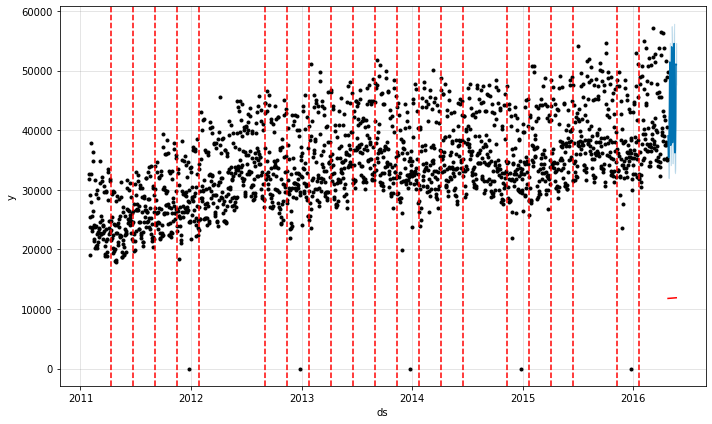

In [145]:
from fbprophet.plot import add_changepoints_to_plot
fig = fb1_forecaster.plot(forecast1)
a = add_changepoints_to_plot(fig.gca(), fb1_forecaster, forecast1)

C:\Users\fast6\anaconda3\lib\site-packages\fbprophet\plot.py:422: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticklabels)
C:\Users\fast6\anaconda3\lib\site-packages\fbprophet\plot.py:422: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticklabels)
C:\Users\fast6\anaconda3\lib\site-packages\fbprophet\plot.py:422: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticklabels)
C:\Users\fast6\anaconda3\lib\site-packages\fbprophet\plot.py:422: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticklabels)


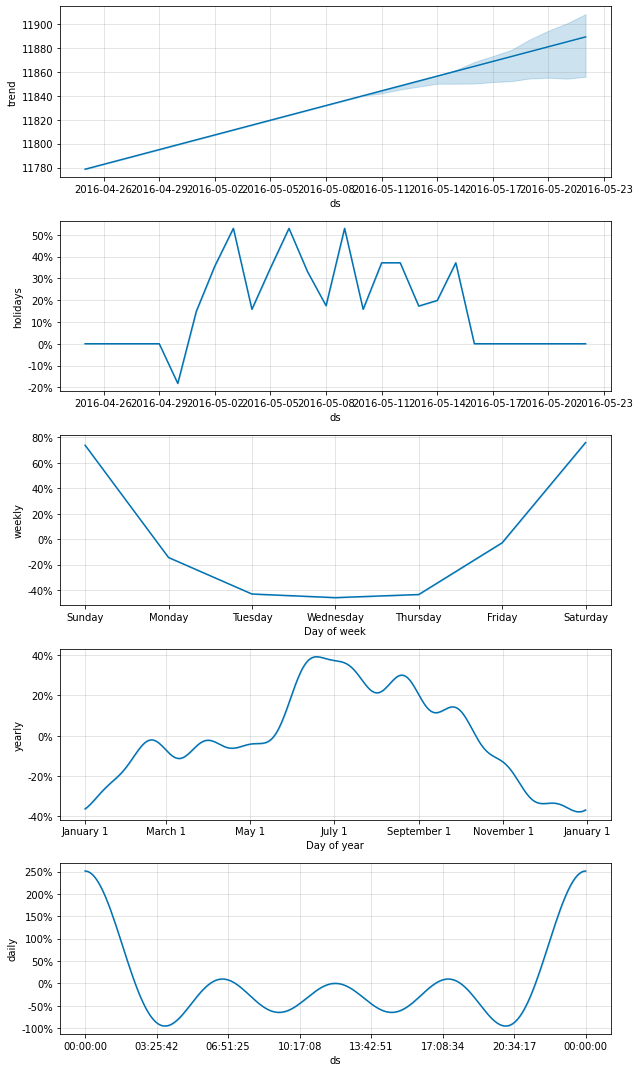

In [146]:
fig = fb1_forecaster.plot_components(forecast1)

In [17]:
z_train.head()

,ds,y
0,2011-01-29,32631.0
1,2011-01-30,31749.0
2,2011-01-31,23783.0
3,2011-02-01,25412.0
4,2011-02-02,19146.0


In [18]:
z_test.head()

,ds,y
1913,2016-04-25,38793.0
1914,2016-04-26,35487.0
1915,2016-04-27,34445.0
1916,2016-04-28,34732.0
1917,2016-04-29,42896.0


          ds          yhat    yhat_lower    yhat_upper
0 2016-04-25  39935.530871  35719.531960  44467.989424
1 2016-04-26  37414.532410  32796.346528  41875.957807
2 2016-04-27  37021.372023  32434.805753  41578.210591
3 2016-04-28  37184.427540  33169.673563  41297.378715
4 2016-04-29  41175.934936  36750.958572  45555.049736


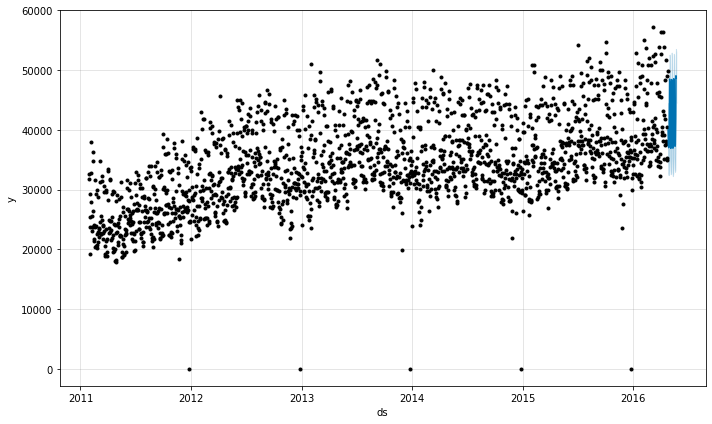

In [34]:
import matplotlib.pyplot as plt
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())
# plot forecast
m.plot(forecast)
plt.show()

In [135]:
pred = forecast1[['ds','yhat']]
pred

,ds,yhat
0,2016-04-25,39069.068312
1,2016-04-26,35726.137126
2,2016-04-27,35425.648502
3,2016-04-28,35749.421365
4,2016-04-29,40581.443128
5,2016-04-30,47761.242021
6,2016-05-01,51449.920622
7,2016-05-02,43510.481649
8,2016-05-03,42184.124101
9,2016-05-04,37477.974305


In [111]:
pred2 = forecast[['ds','yhat']]
pred2

,ds,yhat
0,2011-01-29,30701.763959
1,2011-01-30,30557.860898
2,2011-01-31,23976.383966
3,2011-02-01,24330.173376
4,2011-02-02,24340.320583
...,...,...
1936,2016-05-18,36207.342321
1937,2016-05-19,36620.829289
1938,2016-05-20,41593.565198
1939,2016-05-21,51113.853975


In [87]:
z_test.head()

,ds,y
1913,2016-04-25,38793.0
1914,2016-04-26,35487.0
1915,2016-04-27,34445.0
1916,2016-04-28,34732.0
1917,2016-04-29,42896.0


In [112]:
#z_test.set_index('ds').drop('y')
pred2= pred2.set_index('ds')
#pred= pred.drop(['y'], axis=1)
pred2.head()

,yhat
ds,
2011-01-29,30701.763959
2011-01-30,30557.860898
2011-01-31,23976.383966
2011-02-01,24330.173376
2011-02-02,24340.320583


In [136]:
#z_test.set_index('ds').drop('y')
pred= pred.set_index('ds')
#pred= pred.drop(['y'], axis=1)
pred.head()

,yhat
ds,
2016-04-25,39069.068312
2016-04-26,35726.137126
2016-04-27,35425.648502
2016-04-28,35749.421365
2016-04-29,40581.443128


In [89]:
test.head()

ds
2016-04-25    38793.0
2016-04-26    35487.0
2016-04-27    34445.0
2016-04-28    34732.0
2016-04-29    42896.0
Name: y, dtype: float64

In [90]:
z_test.head()

,ds,y
1913,2016-04-25,38793.0
1914,2016-04-26,35487.0
1915,2016-04-27,34445.0
1916,2016-04-28,34732.0
1917,2016-04-29,42896.0


In [91]:
pred.head()

,yhat
ds,
2016-04-25,38658.346796
2016-04-26,34875.443400
2016-04-27,35166.894907
2016-04-28,35903.015456
2016-04-29,40600.783495


In [137]:
train = z_train.set_index('ds').squeeze()
test = z_test.set_index('ds')
#test= test.drop(['forecast'], axis=1)
test=test.squeeze()
#pred = pred.set_index('ds')
#pred= pred.drop(['y'], axis=1)
pred = pred.squeeze()

In [138]:
train.head()

ds
2011-01-29    32631.0
2011-01-30    31749.0
2011-01-31    23783.0
2011-02-01    25412.0
2011-02-02    19146.0
Name: y, dtype: float64

In [139]:
test.head()

ds
2016-04-25    38793.0
2016-04-26    35487.0
2016-04-27    34445.0
2016-04-28    34732.0
2016-04-29    42896.0
Name: y, dtype: float64

In [140]:
pred = pred.squeeze()

In [141]:
type(pred)

pandas.core.series.Series

In [142]:
pred.head()

ds
2016-04-25    39069.068312
2016-04-26    35726.137126
2016-04-27    35425.648502
2016-04-28    35749.421365
2016-04-29    40581.443128
Name: yhat, dtype: float64

In [98]:
type(pred)

pandas.core.series.Series

0.037610211611148935

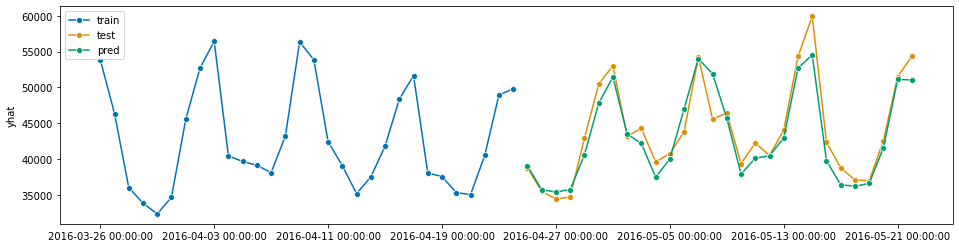

In [143]:
plot_series(train[-30:], test[-30:], pred, labels=['train', 'test', 'pred'])
#plot_series(train, test, pred, labels=['train', 'test', 'pred'])
smape_loss(test, pred)